In [1]:
%matplotlib inline

import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
pd.options.mode.chained_assignment = None #default = 'warn'

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

In [11]:
columns = [
    'mpg', 
    'cylinders', 
    'displacement', 
    'horsepower',
    'weight', 
    'acceleration', 
    'model year',
    'origin', 
    'car name'
]

data = pd.read_csv(auto_mpg_data, sep='\s+', header=None, names=columns)

data_no_missing = data[data['horsepower'] != '?']
data_no_missing['horsepower'] = data_no_missing['horsepower'].astype('float64')
data = data.replace('?', '93.5')
data['horsepower'] = data['horsepower'].astype('float64')

In [3]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [4]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

In [5]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    if h < 1:
        return 1
    return int( h)

Now we can look at our Null and Distributional Models. For our loss function, we want to penalize underestimates and overestimates the same, and penalize larger errors more than smaller errors. This leads us to the Mean Squared Error as our loss function. Thus, our baseline model will simply be the mean of $mpg$. Let's start with reminding ourselves of the summary statistics for $mpg$.

In [6]:
data['mpg'].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Since the mean is 23.5, we can predict that a car will have an $mpg$ rating of 23.5. Now we can create 95% error bounds as well. Remembering that our histogram of $mpg$ in our single variable analysis was fairly symmetric, we can use standard deviation to find the bounds as ($\hat{y}$ - 1.96 * s, $\hat{y}$ + 1.96 * s), where $\hat{y}$ is the predictive value for the model/mean (using $\bar{y}$ - the actual mean), and s is the standard deviation.

In [7]:
mpg_mean = np.mean(data['mpg'])
mpg_std = np.std(data['mpg'])

lower = mpg_mean - 1.96 * mpg_std
upper = mpg_mean + 1.96 * mpg_std

print(f'({lower}, {upper})')

(8.21450110422372, 38.81464462441949)


So we predict that there's a 95% chance a car's $mpg$ rating will be between 8.2 and 38.8 or so.

For the distributional model, we can start with thinking about the data generating story. As we saw in our pairwise EDA analysis, it seems there are a good deal of factors that can affect the $mpg$ of a car - from it's weight, to how much horsepower it can provide, to whether the engine is diesel or gasoline. Since these factors are additive effects that can all contribute to $mpg$, I think we can reasonably estimate $mpg$ with the Gaussian distribution.

We also note that $mpg$ is non-zero. We know the parameters for the Gaussian distribution are the mean and standard deviation. We can estimate the mean ($\mu$) as our mean $\bar{y}$ and our standard deviation ($\sigma$) as _s_ using methods of moments estimators and the values we calculated above.

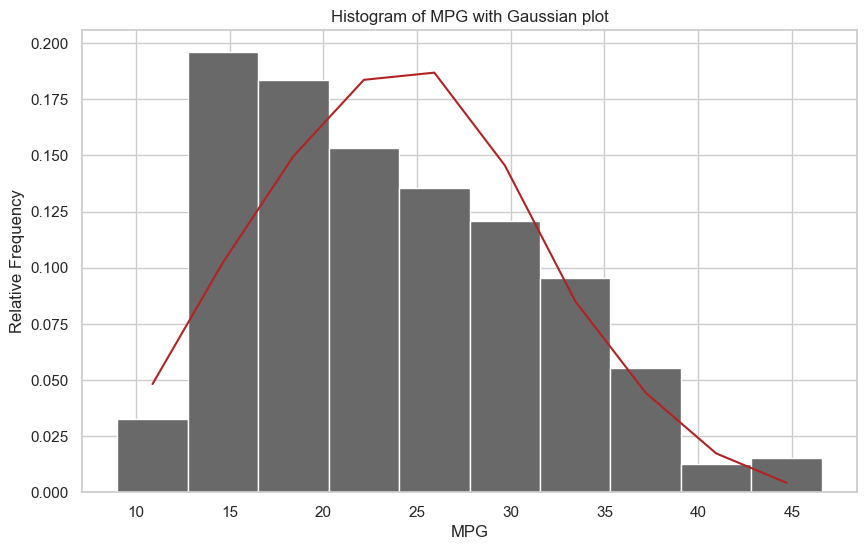

In [12]:
fig = plt.figure(figsize=(10,6))

data_mpg = data['mpg']
mu = np.mean(data_mpg)
std = np.std(data_mpg)


axes = fig.add_subplot(1,1,1)
emp_weights = np.ones(len(data_mpg)) / len(data_mpg)
n, bins, patches = axes.hist(data_mpg, color='dimgray', weights=emp_weights)

axes.set_xlabel('MPG')
axes.set_ylabel('Relative Frequency')
axes.set_title('Histogram of MPG with Gaussian plot')

xs = [(b2+b1)/2 for b1, b2 in zip(bins, bins[1:])]

sampled_data = [mu + r*std for r in np.random.standard_normal(10000)]
samp_weights = np.ones(len(sampled_data)) / len(sampled_data)
vals, base = np.histogram(sampled_data, bins=bins, weights=samp_weights)
axes.plot(xs, vals, color='firebrick')

plt.show()
plt.close()

It looks like this model overestimates $mpg$ near 10, as well as between 20-30, and underestimates $mpg$ around 15-20. We might also be inclined to look at a chart for the difference in cumulative mass between the empirical data and the distributional model. Most of the code presented here follows from *Fundamentals* page 578-579.

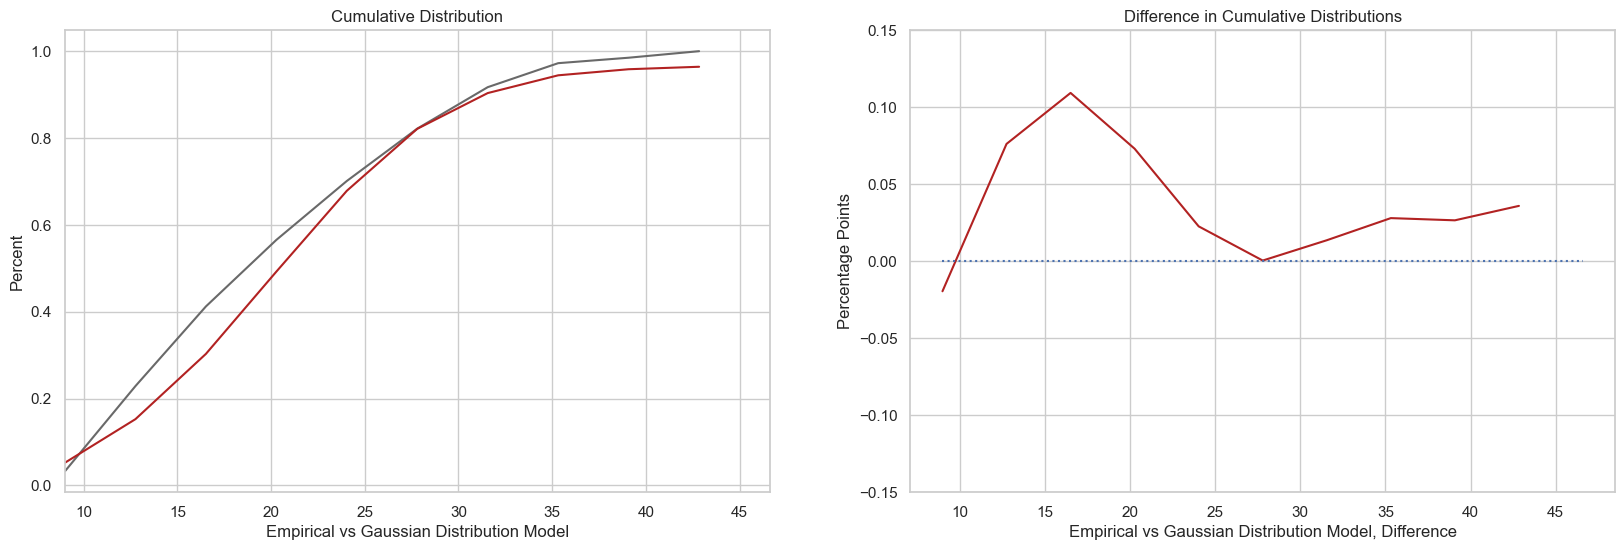

In [18]:
figure = plt.figure(figsize = (20,6))

data_mpg = data['mpg']
data_min = np.min(data_mpg)
data_max = np.max(data_mpg)
mu = np.mean(data_mpg)
std = np.std(data_mpg)

emp_weights = np.ones(len(data_mpg)) / len(data_mpg)
axes = figure.add_subplot(1,2,1)

vals, base = np.histogram(data_mpg, bins=10, weights=emp_weights)
cumulative = np.cumsum(vals)

axes.plot(base[:-1], cumulative, color='dimgray')
axes.set_xlim((data_min, data_max))

sampled_data = [mu + r*std for r in np.random.standard_normal(10000)]
samp_weights = np.ones(len(sampled_data)) / len(sampled_data)
vals2, base = np.histogram(sampled_data, bins=base, weights=samp_weights)
cumulative2 = np.cumsum(vals2)

axes.plot(base[:-1], cumulative2, color='firebrick')
axes.set_title('Cumulative Distribution')
axes.set_xlim((data_min, data_max))
axes.set_ylabel('Percent')
axes.set_xlabel('Empirical vs Gaussian Distribution Model')


axes = figure.add_subplot(1,2,2)
differences = cumulative - cumulative2
axes.plot(base[:-1], differences, color='firebrick')
axes.hlines(0, data_min, data_max, linestyles='dotted')
axes.set_ylim((-0.15,0.15))
axes.set_title('Difference in Cumulative Distributions')
axes.set_xlabel('Empirical vs Gaussian Distribution Model, Difference')
axes.set_ylabel('Percentage Points')


plt.show()
plt.close()


Similar to the histogram, we can see that we underestimate $mpg$ slightly below 10, then overestimate as we get to 12-23 roughly. And overestimate a slightly more around 35 and up.

Finally, let's make a few predictions with this model. For our first prediction, let's ask what is the probability that a random car will have an $mpg$ rating greater than 31.0?

In [ ]:
stats.norm.sf(31.0, )

In [19]:
stats.norm.sf(18, mpg_mean, mpg_std)

0.7600423195612391

About a 76% probability the car will have better than 31.0 $mpg$.

Next, what is the probability that a random car will have an $mpg$ less than 18.0?

In [21]:
stats.norm.cdf(18.0, mpg_mean, mpg_std)

0.23995768043876092

Roughly 24% the car's $mpg$ will be less than 18.0 (remember our first quartile for our data was 17.5) - so this result is relatively consistent.

Finally, what value or lower would we be likely to see with 35% probability?

In [24]:
stats.norm.ppf([0.35], mpg_mean, mpg_std)

array([20.50670001])

We are likely to see $mpg$ of 20.5 and lower with 35% probability.